# ANN - Lab 1b: Logistic Regression #

Tudor Berariu  
Skeleton code from https://github.com/tudor-berariu/ann2018

In [1]:
import numpy as np
%matplotlib notebook
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

## 1. Two datasets

In [2]:
def two_clusters(N, variance=0.1):
    N1 = N // 2
    N2 = N - N1
    X1 = np.random.randn(N1, 2) * variance + 0.25
    X2 = np.random.randn(N2, 2) * variance + 0.75
    X = np.concatenate([X1, X2], axis=0)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

def two_rings(N, separation=0.1, noise=0.2):
    N1 = N // 2
    N2 = N - N1
    angles = np.random.rand(N, 1) * 2 * np.pi
    radius = np.random.rand(N, 1) + np.random.randn(N, 1) * noise
    radius *= .5 - separation / 2
    radius[N2:] += .5 + separation / 2
    X = np.concatenate([radius * np.sin(angles), radius * np.cos(angles)], axis=1)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

In [3]:
def visualize_dataset(X, T, Y=None):
    m = ["x", "o"]  # Indicates true class
    col = ["red", "blue"]  # Indicates prediction
    fig = plt.figure(); plt.axis('equal')
    if Y is not None:
        idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
        idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
        idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
        idx_tn = np.logical_and(T < .5, Y < .5) # True negatives
        
        plt.scatter(X[idx_tp,0], X[idx_tp,1], marker=m[0], c="red", label="TP")
        plt.scatter(X[idx_fp,0], X[idx_fp,1], marker=m[1], c="red", label="FP")
        plt.scatter(X[idx_fn,0], X[idx_fn,1], marker=m[0], c="blue", label="FN")
        plt.scatter(X[idx_tn,0], X[idx_tn,1], marker=m[1], c="blue", label="TN")

    else:
        idx_pos, idx_neg = (T > .5), (T < .5)
        plt.scatter(X[idx_pos,0], X[idx_pos,1], marker=m[0], color="blue", label="Pos")
        plt.scatter(X[idx_neg,0], X[idx_neg,1], marker=m[1], color="blue", label="Neg")
    
    plt.xlabel("x"); plt.ylabel("y")
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    return fig.axes[0]

<IPython.core.display.Javascript object>


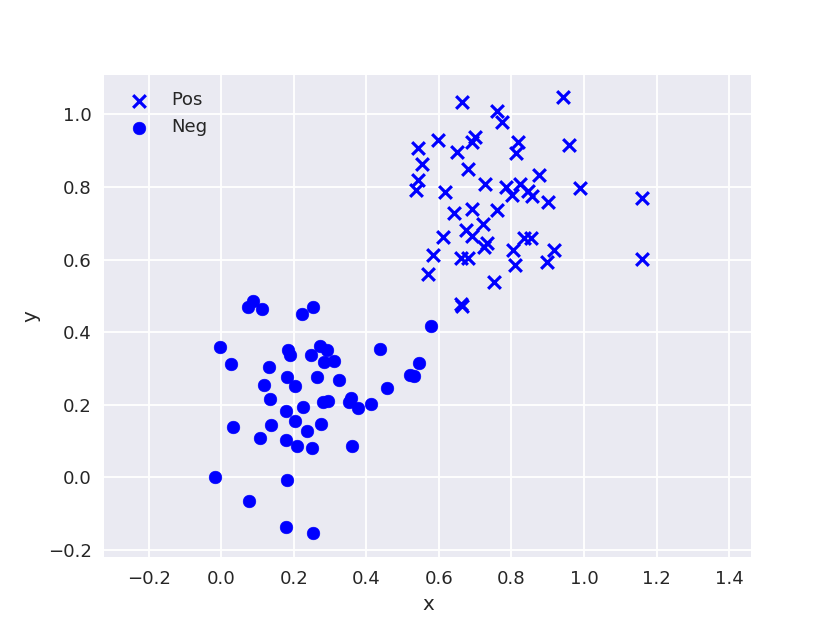

<IPython.core.display.Javascript object>


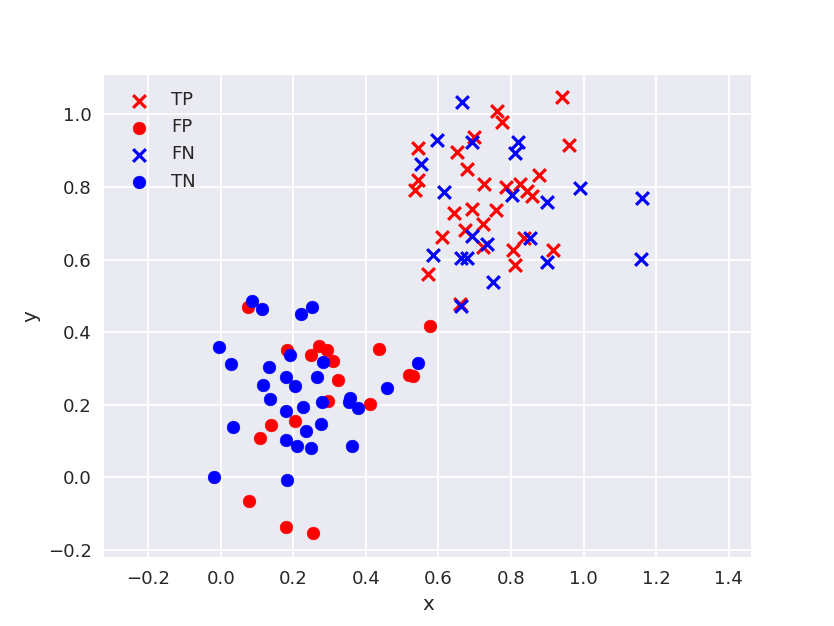

In [4]:
X, T = two_clusters(100, variance=0.15)
visualize_dataset(X, T, Y=None);
visualize_dataset(X, T, Y=np.random.uniform(size=T.size));

<IPython.core.display.Javascript object>


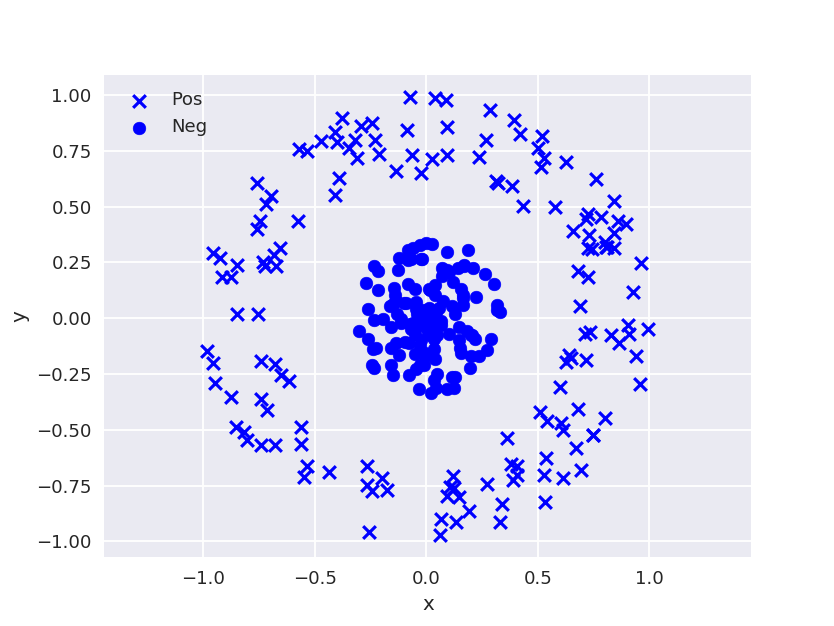

<IPython.core.display.Javascript object>


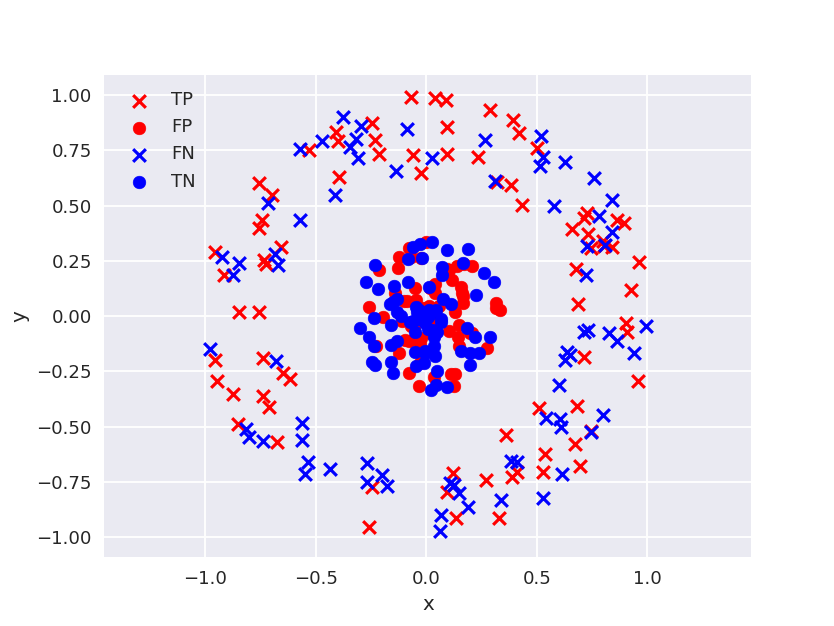

In [5]:
X, T = two_rings(300, noise=0.01, separation=.3)
visualize_dataset(X, T, Y=None);
visualize_dataset(X, T, Y=np.random.uniform(size=T.size));

## 2. Using linear regression for classification?

We'll use the following convention: ${\bf w}^{\text{T}}{\bf x} + b = 1$ for positive examples and ${\bf w}^{\text{T}}{\bf x} +b = 0$ for negative examples.

Actually: $\hat{x} = [x_0, x_1, 1]$ and $y = {\bf w}^{\text{T}}\hat{{\bf x}}$

In [6]:
def train_linear(X, T):
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.dot(np.linalg.pinv(X_hat), T)
    return W

In [7]:
def predict_linear(X, W):
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    Y = np.dot(X_hat, W)
    return Y

<IPython.core.display.Javascript object>


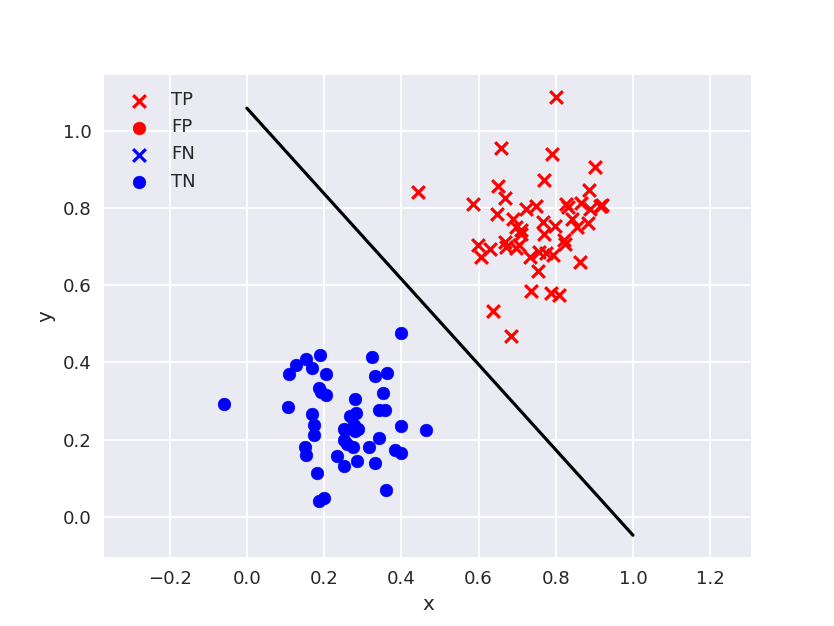

In [8]:
X, T = two_clusters(100, variance=0.1)
W = train_linear(X, T)
Y = predict_linear(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)


### How about adding some other examples that should pose no problems?

<IPython.core.display.Javascript object>


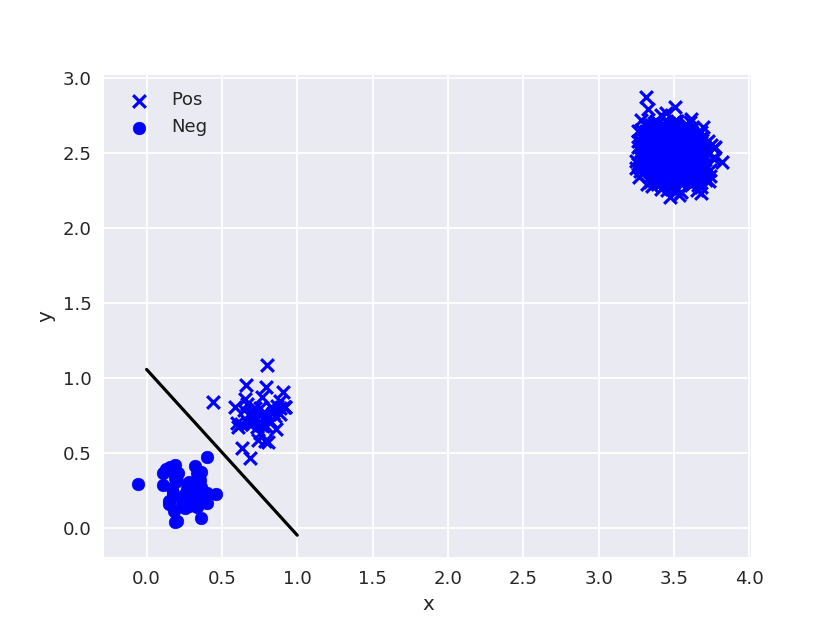

In [9]:
extra_N = 800
extra_X = np.random.randn(extra_N, 2) * 0.1
extra_X[:,1] += 2.5
extra_X[:,0] += 3.5
extra_T = np.ones(extra_N)
X_full = np.concatenate([X, extra_X], axis=0)
T_full = np.concatenate([T, extra_T], axis=0)

ax = visualize_dataset(X_full, T_full, Y=None);
__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)

### Let's train the model on full data

<IPython.core.display.Javascript object>


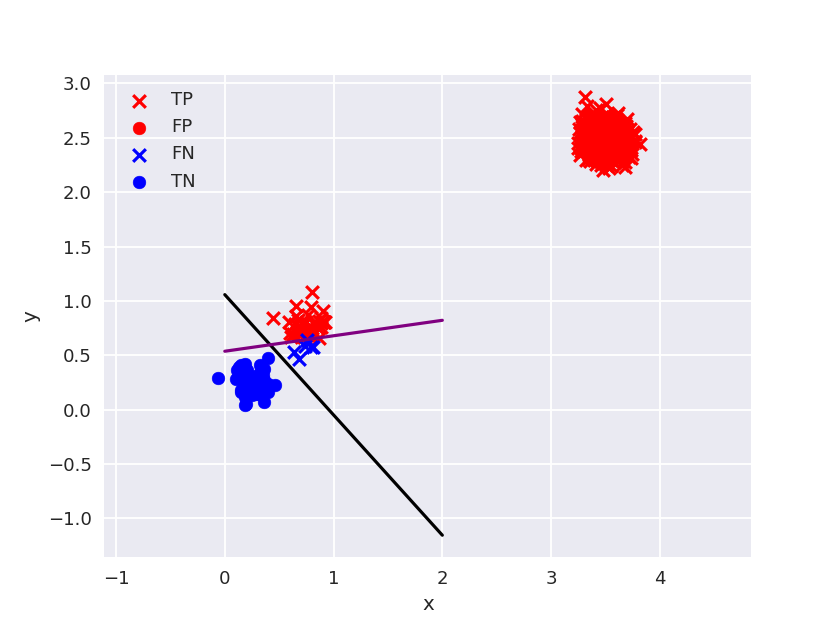

In [10]:
W_full = train_linear(X_full, T_full)
Y = predict_linear(X_full, W_full)
ax = visualize_dataset(X_full, T_full, Y);

__x = np.linspace(0,2, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]
plt.plot(__x, __y, c="black", axes=ax)

__y = (.5 - __x * W_full[0] - W_full[2]) / W_full[1]
plt.plot(__x, __y, c="purple", axes=ax)

## The logistic function

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$


In [11]:
def logistic(x):
    return 1. / (1. + np.exp(-x))

<IPython.core.display.Javascript object>


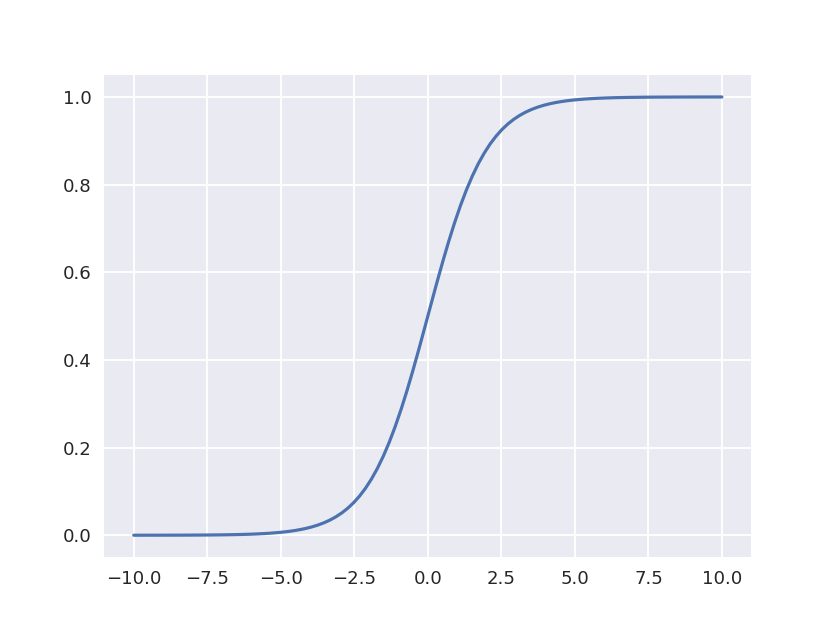

In [12]:
x = np.linspace(-10, 10, 100)
plt.figure()
plt.plot(x, logistic(x))

## 3. Learning models for classification

In [13]:
def nll(Y, T):
    idx0 = (T > 0.5)
    idx1 = (T < 0.5)
    return -np.sum(np.log(Y[idx0])) - np.sum(np.log(1.0 - Y[idx1]))

def accuracy(Y, T):
    N = Y.shape[0]
    return np.sum(((T < 0.5) & (Y < 0.5)) | ((T > 0.5) & (Y > 0.5))) / N

print("NLL:", nll(np.random.uniform(size=(100)), T))
print("Accuracy: ", accuracy(np.random.uniform(size=(100)), T))

NLL: 98.12645634092242
Accuracy:  0.51


In [14]:
def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train,:], X[N_train:,:]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test


## 4. Logistic regression

In [15]:
def train_logistic(X, T, lr=.01, epochs_no=10):
    # TODO <1> : Make epochs_no steps of SGD
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.random.randn((D+1))
    
    for _ in range(epochs_no):
        # forward
        scores = np.dot(X_hat, W)
        Y = logistic(scores)
        
        # dloss_dscores
        dloss_dscores = Y - T

        # dloss_dw
        dloss_dw = np.sum(X_hat * dloss_dscores[:, None], axis=0)
        
        # SGD step
        W -= lr * dloss_dw
        
    return W

def predict_logistic(X, W):
    # TODO <2> : Compute the model's predictions
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    Y = logistic(np.dot(X_hat, W))
    return Y

### Let's test it!

<IPython.core.display.Javascript object>


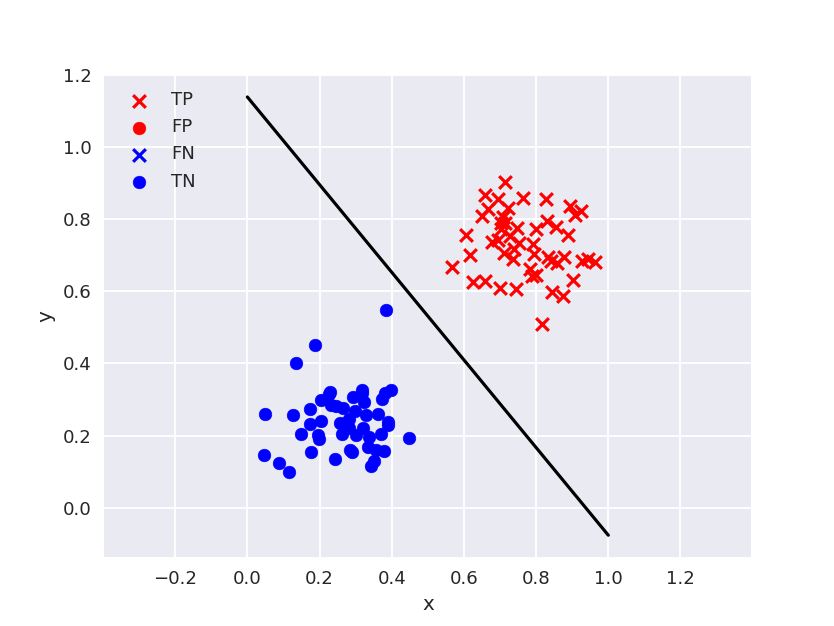

In [16]:
X, T = two_clusters(100, variance=0.1)
W = train_logistic(X, T, lr=.1, epochs_no=1000)
Y = predict_logistic(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(0, 1, 100)
__y = (-__x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)

<IPython.core.display.Javascript object>


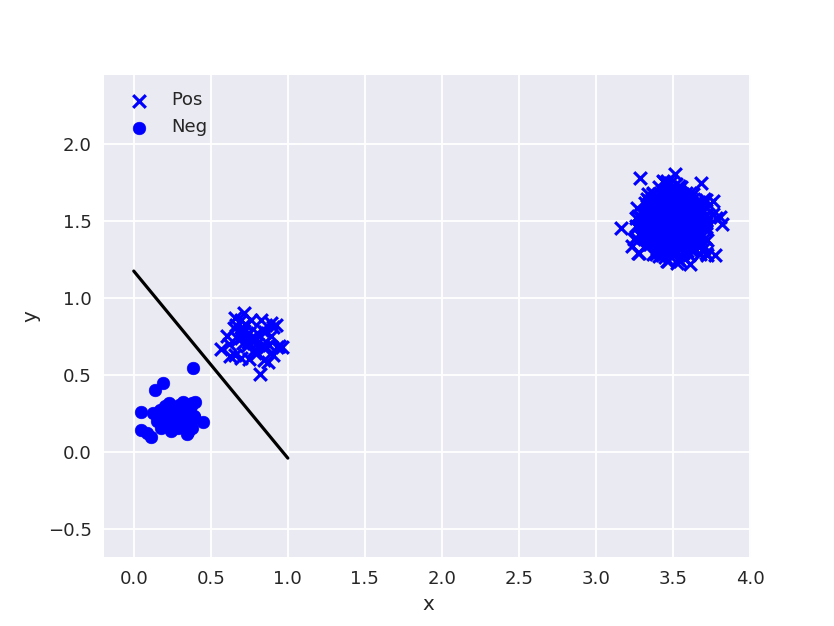

In [17]:
extra_N = 800
extra_X = np.random.randn(extra_N, 2) * 0.1
extra_X[:,1] += 1.5
extra_X[:,0] += 3.5
extra_T = np.ones(extra_N)
X_full = np.concatenate([X, extra_X], axis=0)
T_full = np.concatenate([T, extra_T], axis=0)

ax = visualize_dataset(X_full, T_full, Y=None);
__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)

<IPython.core.display.Javascript object>


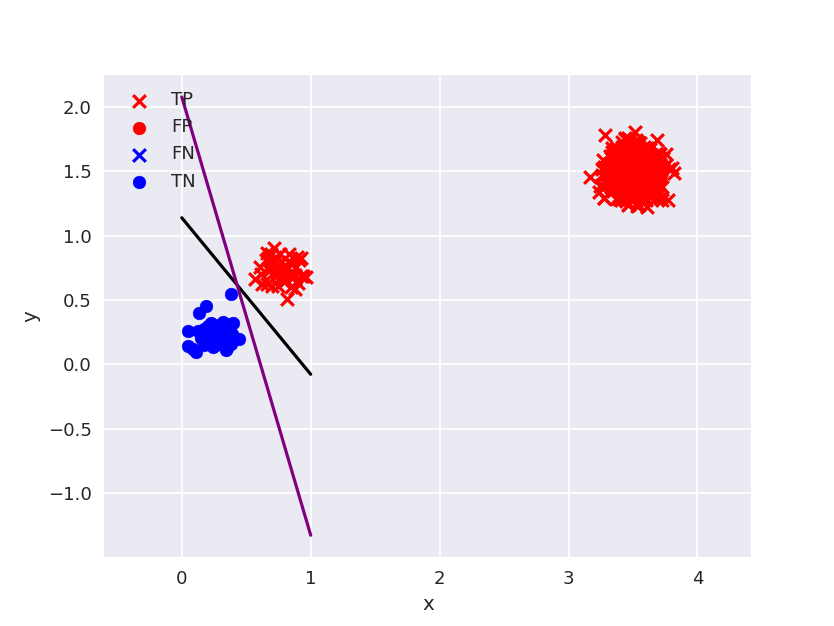

In [18]:
W_full = train_logistic(X_full, T_full, lr=.1, epochs_no=10000)
Y = predict_logistic(X_full, W_full)
ax = visualize_dataset(X_full, T_full, Y);

__x = np.linspace(0, 1, 100)
__y = (- __x * W[0] - W[2]) / W[1]
plt.plot(__x, __y, c="black", axes=ax)

__y = (- __x * W_full[0] - W_full[2]) / W_full[1]
plt.plot(__x, __y, c="purple", axes=ax)


### What happens?

In [19]:
def train_logistic_full(X, T, lr=.01, epochs_no=100):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)
    W = np.random.randn((D+1))

    X_train, T_train, X_test, T_test = split_dataset(X1, T)

    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        Y_train = logistic(np.dot(X_train, W))
        # Update parameters
        W -= lr * np.dot(X_train.T, Y_train-T_train)

        # Just for plotting
        Y_test = 1. / (1. + np.exp(-np.dot(X_test, W)))
        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())
        
    return W, train_acc, test_acc, train_nll, test_nll, W_trace

In [20]:
def plot_evolution(train_acc, test_acc, train_nll, test_nll):
    epochs_no = len(train_acc)
    fig, (ax1, ax2) = plt.subplots(2,1);
    ax1.plot(range(epochs_no), train_acc, sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(epochs_no), test_acc, sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    ax2.plot(range(epochs_no), train_nll, sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(epochs_no), test_nll, sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1);
    return (ax1, ax2)

<IPython.core.display.Javascript object>


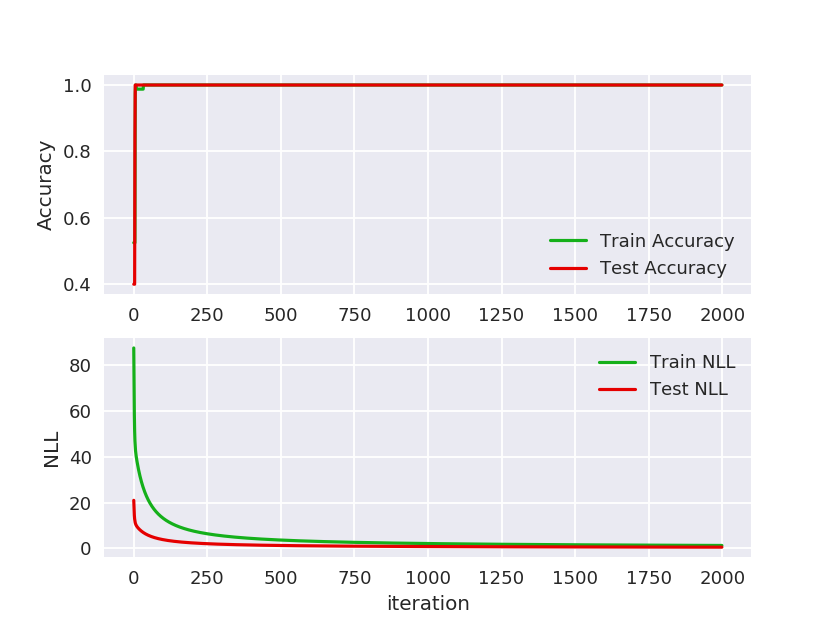

In [21]:
EPOCHS_NO = 2000
results = train_logistic_full(X, T, lr=.01, epochs_no=EPOCHS_NO)

W, train_acc, test_acc, train_nll, test_nll, W_trace = results
plot_evolution(train_acc, test_acc, train_nll, test_nll);


del EPOCHS_NO, results, W, train_acc, test_acc, train_nll, test_nll, W_trace

## What about the second dataset?

<IPython.core.display.Javascript object>


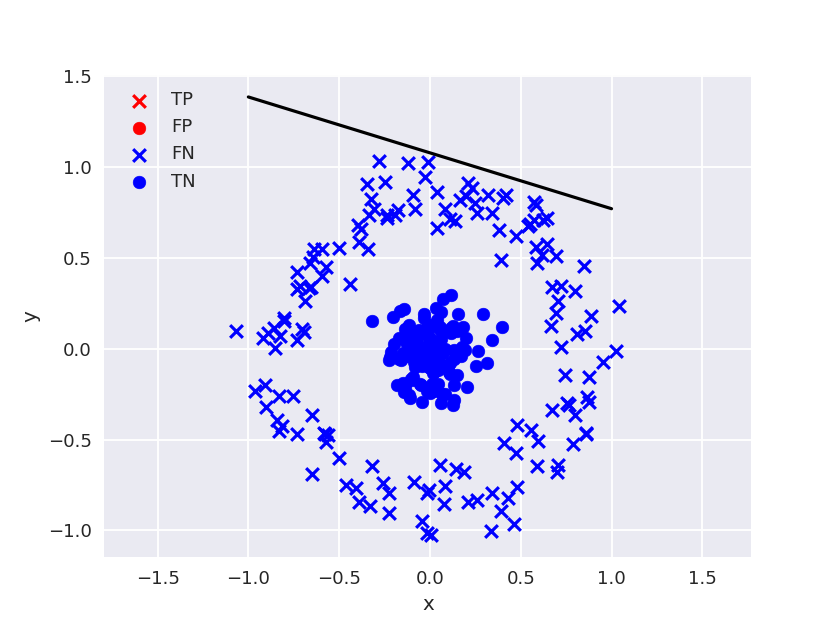

In [22]:
X, T = two_rings(300, separation=.4)
W = train_logistic(X, T, lr=.1, epochs_no=1000)
Y = predict_logistic(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(-1, 1, 100)
__y = (-__x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)